# Creating a New Pipeline Operation

This guide will walk you through creating a custom Pipeline Operation in AFL-agent. Pipeline Operations are the building blocks of AFL-agent pipelines - they perform specific data transformations and analyses that can be chained together. By creating your own Pipeline Operation, you can extend AFL-agent's functionality to meet your specific needs.


In this tutorial, we'll a `PipelineOp`s that implements a new data normalization algorithm.

Let's start by importing the parent PipelineOp class. All pipeline operations should import this directly or indirectly through another parent class.

In [1]:
from AFL.double_agent.PipelineOp import PipelineOp

Now let's define the `PipelineOp` sub-class. It should have two methods:

1. a constructor called __init__
2. a method called calculate that takes a single argument

In [10]:
class MyNormalizer(PipelineOp):
    def __init__(self, input_variable, output_variable, name="MyNormalizer"):
        # The PipelineOp constructor takes three arguments and stores them as attributes
        super().__init__(
            input_variable=input_variable,
            output_variable=output_variable,
            name=name
        )

    def calculate(self, dataset):
        # Extract the data variable to be normalized from the dataset
        data = self._get_variable(dataset)

        # Perform your normalization logic here
        normalized_data = data/data.max()

        # Store the normalized data in the output variable
        self.output[self.output_variable] = normalized_data
        self.output[self.output_variable].attrs["description"] = "Normalized data"

        # All PipelineOps should return self
        return self

Let's test it out! First we need to load data

In [4]:
import xarray as xr

ds = xr.load_dataset('../data/example_dataset.nc')
ds

<xarray.Dataset> Size: 164kB
Dimensions:              (sample: 100, component: 2, x: 150, grid: 2500)
Coordinates:
  * component            (component) <U1 8B 'A' 'B'
  * x                    (x) float64 1kB 0.001 0.001047 0.001097 ... 0.9547 1.0
Dimensions without coordinates: sample, grid
Data variables:
    composition          (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels  (sample) int64 800B 1 1 0 1 0 1 1 1 ... 1 1 1 1 1 0 1 1
    measurement          (sample, x) float64 120kB 1.915e+06 1.479e+06 ... 1.885
    composition_grid     (grid, component) float64 40kB 0.0 0.0 ... 10.0 25.0

Now let's add our new `PipelineOp` to a `Pipeline` and run the calculation

In [13]:
from AFL.double_agent import *

with Pipeline() as pipeline:
    MyNormalizer(
        input_variable='measurement', 
        output_variable='normalized_measurement'
    )

ds_result = pipeline.calculate(ds)
ds_result

  0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset> Size: 284kB
Dimensions:                 (sample: 100, component: 2, x: 150, grid: 2500)
Coordinates:
  * component               (component) <U1 8B 'A' 'B'
  * x                       (x) float64 1kB 0.001 0.001047 ... 0.9547 1.0
Dimensions without coordinates: sample, grid
Data variables:
    composition             (sample, component) float64 2kB 5.7 1.36 ... 5.104
    ground_truth_labels     (sample) int64 800B 1 1 0 1 0 1 1 ... 1 1 1 1 0 1 1
    measurement             (sample, x) float64 120kB 1.915e+06 ... 1.885
    composition_grid        (grid, component) float64 40kB 0.0 0.0 ... 10.0 25.0
    normalized_measurement  (sample, x) float64 120kB 0.7918 ... 7.794e-07

We can plot the results side by size to compare them

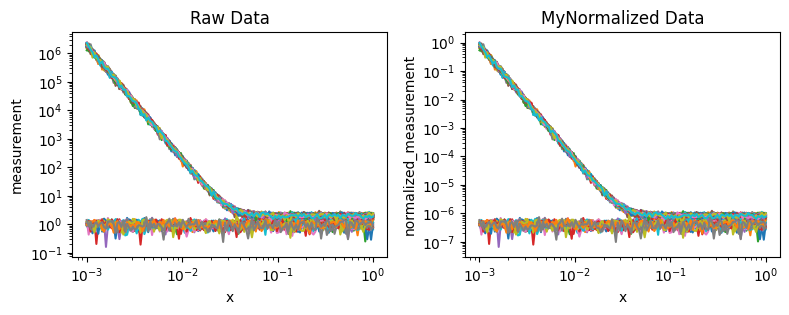

In [15]:
fig,axes = plt.subplots(1,2,figsize=(8,3.25))

ds_result.measurement.plot.line(x='x',xscale='log',yscale='log',ax=axes[0],add_legend=False)
ds_result.normalized_measurement.plot.line(x='x',xscale='log',yscale='log',ax=axes[1],add_legend=False)

axes[0].set(title="Raw Data")
axes[1].set(title="MyNormalized Data")
fig.tight_layout()

Note the differences in the y-axis!

## Conclusion

In this tutorial, we learned how to:

- Create a custom `PipelineOp` by subclassing the base class
- Define the required `calculate` method to implement our data processing logic
- Add our new operation to a `Pipeline` and execute it on a dataset
- Visualize the results to confirm our normalization worked as expected

Custom `PipelineOp` classes allow you to extend AFL's functionality with your own data processing operations.
